In [1]:
from itertools import islice
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from einops import einops as ein
from jaxtyping import Bool, Float, Int
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer

%load_ext autoreload
%autoreload 2

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")
dataset = load_dataset("Mlxa/nested", streaming=True)["train"]

In [3]:
from utils import sh, ls
from activation_analysis import (
    input_output_mapping,
    fit_linear,
    eval_module,
    Residual,
    PrefixMean,
)


@typed
def get_prompts(n: int, n_tokens: int) -> list[str]:
    return [
        " ".join(tokenizer.tokenize(elem["text"])[:n_tokens])
        for elem in islice(dataset, n)
    ]

In [13]:
layer = "transformer.h.7.mlp"

In [4]:
X_sae, Y_sae = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(100000, n_tokens=16),
    input_layer=layer,
    output_layer=layer,
)
# Y_sae -= X_sae

idx = t.randint(0, 16, size=(10 ** 5,))
X_selected = t.zeros((10 ** 5, 256))
Y_selected = t.zeros((10 ** 5, 256))
for i in range(len(idx)):
    X_selected[i] = X_sae[i, idx[i]]
    Y_selected[i] = Y_sae[i, idx[i]]

In [4]:
from sparse_autoencoders import fit_sae, SparseAutoEncoder

# activation_data = ein.rearrange(Y_sae, "prompts seq d -> (prompts seq) d")
activation_data = t.load("activations/L7_mlp.pt")

In [5]:
sae = SparseAutoEncoder(256, 64)

In [6]:
others = [SparseAutoEncoder(256, d) for d in [100, 120]]

In [8]:
for other in others:
    fit_sae(other, activation_data, lr=1e-2, l1=0.1, alpha=1e-4, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:06<00:00,  1.35s/it,  loss=0.00, nonzero=23.50 / 120, nonorth=0.12]


In [9]:
fit_sae(sae, activation_data, lr=1e-3, l1=0.5, alpha=1e-2, epochs=20)

100%|██████████| 20/20 [00:23<00:00,  1.16s/it,  loss=0.00, nonzero=18.97 / 64, nonorth=0.01]


In [10]:
with t.no_grad():
    some_activations = activation_data[::11]
    guess = sae.encode(some_activations)
    other_guesses = [other.encode(some_activations) for other in others]

In [11]:
from sparse_autoencoders import max_cosine_similarity

sims = [max_cosine_similarity(guess, other) for other in other_guesses]
mean_sim = sum(sims) / len(sims)
print(ls(sims[0].mean()), ls(sims[0]))
print(ls(sims[1].mean()), ls(sims[1]))

0.60 [ 0.24 0.80 0.75 0.55 0.51 0.64 0.87 0.85 0.71 0.44 0.48 0.66 0.51 0.94 0.50 0.50 0.70 1.00 0.51 0.58 0.62 0.90 0.49 0.48 0.81 0.51 0.90 0.96 0.62 0.89 0.37 1.00 0.63 0.49 0.50 0.80 0.69 0.27 0.56 0.55 0.45 0.56 0.91 0.18 0.90 0.38 0.35 0.27 0.59 0.54 0.97 0.60 0.00 0.58 0.55 0.64 0.52 0.56 0.51 0.72 0.20 0.63 0.51 0.57 ]
0.58 [ 0.23 0.85 0.77 0.62 0.57 0.49 0.49 0.85 0.52 0.52 0.49 0.71 0.52 0.94 0.42 0.53 0.51 1.00 0.61 0.60 0.58 0.90 0.52 0.49 0.84 0.71 0.90 0.96 0.68 0.48 0.30 1.00 0.55 0.54 0.52 0.86 0.53 0.32 0.59 0.51 0.53 0.49 0.91 0.20 0.90 0.31 0.15 0.31 0.54 0.53 0.97 0.57 0.00 0.51 0.55 0.52 0.52 0.53 0.51 0.52 0.16 0.52 0.71 0.57 ]


In [14]:
from activation_analysis import compressed_activations
from language_modeling import prompt_from_template, generate_sample, get_logprobs
import plotly.express as px
from tqdm import tqdm


prefixes: list[str] = []
suffixes: list[str] = []
compressed: list[Float[TT, "d"]] = []
prefix_cutoff = 16

for prompt in tqdm(get_prompts(4000, n_tokens=prefix_cutoff)):
    tokens = tokenizer.tokenize(prompt)
    short_prompt = " ".join(tokens)
    res = compressed_activations(model, tokenizer, short_prompt, {layer: sae})[layer]
    assert_type(res, Float[TT, "n d"])
    logprobs = get_logprobs(model, tokenizer,  short_prompt)
    next_tokens = t.multinomial(logprobs.roll(-1, dims=0).exp(), 1).squeeze().tolist()
    for i in range(8, 16):
        prefix = " ".join(tokens[: i + 1])
        prefixes.append(prefix)
        suffixes.append(tokenizer.convert_ids_to_tokens(next_tokens[i]))
        compressed.append(res[i])

100%|██████████| 4000/4000 [01:32<00:00, 43.37it/s]


In [15]:
@typed
def show_activations(activations: Float[TT, "n d"], perm: Int[TT, "k"]) -> None:
    fig = px.imshow(
        activations[:, perm],
        color_continuous_scale=px.colors.diverging.RdBu,
        labels={"x": "Dimension", "y": "Prompt", "color": "Activation"},
        x=[str(elem.item()) for elem in perm],
        # y=prefixes,
        # zmin=-1,
        # zmax=1,
    )
    fig.show()


stacked = t.stack(compressed)
stds = stacked.std(dim=0)
std_argsort = t.tensor(list(stds.argsort())[::-1])
important_dirs = std_argsort[:53]
# stacked -= stacked.mean(dim=0, keepdim=True)
# stacked /= stacked.norm(dim=0, keepdim=True)
show_activations(stacked[:100], perm=important_dirs)

In [16]:
stacked = t.stack(compressed)
for pos, i in enumerate(std_argsort[:50]):
    print(
        f"{pos}) dim: {i.item()}\tstd: {ls(stds[i])}\tsim: {ls(sims[0][i])}\t other sim: {ls(sims[1][i])}"
    )

0) dim: 17	std: 594.48	sim: 1.00	 other sim: 1.00
1) dim: 54	std: 101.65	sim: 0.55	 other sim: 0.55
2) dim: 55	std: 98.33	sim: 0.64	 other sim: 0.52
3) dim: 4	std: 93.34	sim: 0.51	 other sim: 0.57
4) dim: 3	std: 93.34	sim: 0.55	 other sim: 0.62
5) dim: 9	std: 92.48	sim: 0.44	 other sim: 0.52
6) dim: 53	std: 91.29	sim: 0.58	 other sim: 0.51
7) dim: 11	std: 90.63	sim: 0.66	 other sim: 0.71
8) dim: 8	std: 90.44	sim: 0.71	 other sim: 0.52
9) dim: 18	std: 89.92	sim: 0.51	 other sim: 0.61
10) dim: 28	std: 88.40	sim: 0.62	 other sim: 0.68
11) dim: 48	std: 87.40	sim: 0.59	 other sim: 0.54
12) dim: 31	std: 87.33	sim: 1.00	 other sim: 1.00
13) dim: 49	std: 87.33	sim: 0.54	 other sim: 0.53
14) dim: 39	std: 87.24	sim: 0.55	 other sim: 0.51
15) dim: 23	std: 86.65	sim: 0.48	 other sim: 0.49
16) dim: 20	std: 86.23	sim: 0.62	 other sim: 0.58
17) dim: 25	std: 85.94	sim: 0.51	 other sim: 0.71
18) dim: 41	std: 85.01	sim: 0.56	 other sim: 0.49
19) dim: 59	std: 83.76	sim: 0.72	 other sim: 0.52
20) dim: 12	

In [18]:
from activation_analysis import feature_effect

short_prompts = [
    ("<10 <11 <12 12> 11> 10>", 1),
    ("<3 <4 <5 5> 4> 3>", 1),
    ("<8 <2 <7 7> 2> 8>", 1),
    ("<10 <11 <12 12> 11> 10>", 2),
    ("<3 <4 <5 5> 4> 3>", 2),
]

inspected_direction = 27

for prompt, position in short_prompts:
    eps = 1e2

    effect = feature_effect(
        model,
        tokenizer,
        prompt,
        position,
        directions={layer: (sae, inspected_direction)},
        eps=eps,
    )

    d = effect.base[f"lm_head"] * 0 + effect.diff[f"lm_head"]
    print(f"{prompt} (pos={position})")

    r = 0.002 * eps
    window = 50
    px.imshow(
        d[:, :window].detach(),
        zmin=-r,
        zmax=r,
        color_continuous_scale=px.colors.diverging.RdBu,
        x=[tokenizer.decode(i) for i in range(window)],
    ).show()

    # window = 500
    # px.imshow(
    #     d[:, 1:window:2].detach(),
    #     color_continuous_scale=px.colors.diverging.RdBu,
    #     x=[tokenizer.decode(2 * i + 1) for i in range(window//2)],
    # ).show()


<10 <11 <12 12> 11> 10> (pos=1)


<3 <4 <5 5> 4> 3> (pos=1)


<8 <2 <7 7> 2> 8> (pos=1)


<10 <11 <12 12> 11> 10> (pos=2)


<3 <4 <5 5> 4> 3> (pos=2)


In [19]:
values = t.tensor([a[inspected_direction] for a in compressed])
perm = values.argsort()

for i in perm[::100]:
    print(ls(values[i]), "   \t", prefixes[i], "#", suffixes[i])

0.00    	 <169 169> <184 184> <139 <4 4> 139> <223 # <172
0.00    	 <40 <35 <79 79> <110 110> 35> <93 93> 40> <3 <12 12> # 3>
0.00    	 <1 1> <85 85> <190 190> <71 71> <60 # 60>
0.00    	 <119 <52 <125 <236 <21 <193 <158 158> 193> <246 # <159
0.00    	 <244 244> <42 42> <40 <156 156> 40> <91 <217 217> <73 # 73>
0.00    	 <24 <192 192> <225 <160 160> 225> 24> <125 # 125>
0.00    	 <173 173> <10 10> <44 44> <85 <6 <6 6> 6> <93 93> <214 # 214>
0.00    	 <25 25> <222 <2 <76 76> <157 <185 185> <79 79> 157> <77 <49 # <107
0.00    	 <34 34> <51 <15 15> 51> <105 <190 190> # <19
0.00    	 <190 190> <77 <21 21> <18 18> 77> <152 <184 184> # 152>
0.00    	 <114 <53 <44 <116 <74 <155 155> <60 60> 74> <22 22> 116> <111 <65 # 65>
0.00    	 <15 <73 73> <188 188> 15> <110 110> <45 <205 <77 77> <165 <2 <214 214> # 2>
0.00    	 <31 31> <13 13> <250 250> <67 <116 116> <201 <121 <19 19> # <110
0.00    	 <69 <46 46> <225 <41 <221 221> <116 <27 # 27>
0.00    	 <93 <219 <11 <18 <116 <77 <86 86> <248 # <160
0.

In [20]:
from language_modeling import get_balances
from collections import Counter

segments = 16
for segment in range(segments):
    l, r = segment * len(perm) // segments, (segment + 1) * len(perm) // segments
    prefix_ends_open = []
    suffix_starts_open = []
    prefix_balance = []
    prefix_length = []
    feature_values = []
    prefix_tokens = Counter()
    last_tokens = Counter()
    suffix_tokens = Counter()
    for i in perm[l:r]:
        balances = get_balances(prefixes[i])
        feature_values.append(values[i].item())
        prefix_balance.append(balances[-1].item())
        prefix_length.append(len(tokenizer.tokenize(prefixes[i])))
        suffix_starts_open.append(suffixes[i].startswith("<"))
        prefix_ends_open.append(not prefixes[i].endswith(">"))
        prefix_tokens.update(tokenizer.tokenize(prefixes[i]))
        last_tokens.update(tokenizer.tokenize(prefixes[i])[-1:])
        suffix_tokens.update(tokenizer.tokenize(suffixes[i])[:1])
    avg = lambda x: sum(x) / len(x)
    Counter.get_freqs = lambda self: [
        (k, round(v / self.total(), 3)) for k, v in self.most_common(10)
    ]
    print(f"segment {segment}: {ls(min(feature_values))}, {ls(max(feature_values))}")
    # idx_to_check = [
    #     tokenizer.encode(s)[0] for s in ["<4", "4>", "<8", "8>", "<12", "12>"]
    # ]
    # print(
    #     *idx_to_check, ":", tokenizer.decode(idx_to_check), ":", *[suffix_tokens[i] for i in idx_to_check]
    # )
    print(
        f"last open = {avg(prefix_ends_open)}, next open = {avg(suffix_starts_open)}, balance: {np.quantile(prefix_balance, [0.1, 0.25, 0.5, 0.75, 0.9])} mean = {avg(prefix_balance)}, length = {np.quantile(prefix_length, [0.1, 0.25, 0.5, 0.75, 0.9])} mean = {avg(prefix_length)}"
    )
    print("prefix (full)", prefix_tokens.total(), prefix_tokens.get_freqs())
    print("prefix (last)", last_tokens.total(), last_tokens.get_freqs())
    print("suffix (first)", suffix_tokens.total(), suffix_tokens.get_freqs())
    print()

segment 0: 0.00, 0.00
last open = 0.6565, next open = 0.399, balance: [1. 1. 2. 3. 4.] mean = 2.2945, length = [ 9.  11.  13.  15.  15.1] mean = 12.3985
prefix (full) 24797 [('<21', 0.005), ('<34', 0.005), ('<180', 0.005), ('<148', 0.004), ('<110', 0.004), ('<236', 0.004), ('<78', 0.004), ('<25', 0.004), ('<73', 0.004), ('<190', 0.004)]
prefix (last) 2000 [('<41', 0.006), ('<172', 0.006), ('<80', 0.006), ('<59', 0.005), ('<227', 0.005), ('<86', 0.005), ('<218', 0.005), ('<236', 0.005), ('<240', 0.005), ('<204', 0.005)]
suffix (first) 2000 [('95>', 0.007), ('25>', 0.006), ('106>', 0.006), ('172>', 0.006), ('236>', 0.006), ('110>', 0.006), ('59>', 0.006), ('225>', 0.006), ('218>', 0.005), ('204>', 0.005)]

segment 1: 0.00, 0.00
last open = 0.639, next open = 0.404, balance: [1. 1. 2. 3. 4.] mean = 2.264, length = [ 9.  11.  13.  15.  15.1] mean = 12.41
prefix (full) 24820 [('<9', 0.005), ('<144', 0.005), ('<168', 0.004), ('<162', 0.004), ('<92', 0.004), ('<106', 0.004), ('<34', 0.004), (

17: [ 0.01 0.00 0.00 0.00 0.00 1.84 ]
27: [ 0.00 0.00 0.00 0.00 0.00 1.46 ]


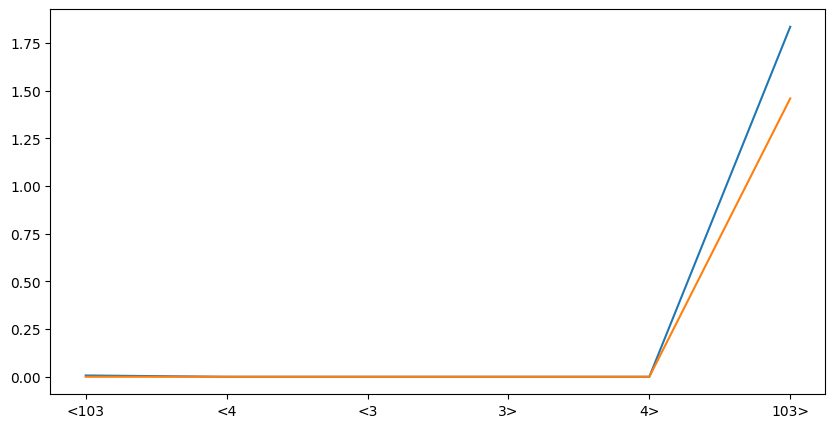

In [34]:
@typed
def explore_input(user_input: str, features: list[int]) -> None:
    tokens = tokenizer.encode(user_input)
    if any(x >= len(tokenizer) - 2 for x in tokenizer.encode(user_input)):
        print("Invalid input. Please try again.")
    cur = compressed_activations(model, tokenizer, user_input, {layer: sae})[layer]
    str_tokens = tokenizer.tokenize(user_input)
    str_tokens = [f"{tok}" for i, tok in enumerate(str_tokens)]
    r = 200
    plt.figure(figsize=(10, 5))
    for feature in features:
        normalized = cur[:, feature] / stds[feature]
        print(f"{feature}: {ls(normalized)}")
        plt.plot(str_tokens, normalized)
    plt.show()

for prompt in get_prompts(n=10, n_tokens=32):
    features = [17, 27]
    explore_input(prompt, features)

In [17]:
covar = sae.decoder[std_argsort] @ sae.decoder[std_argsort].T
px.imshow(covar.detach()).show()
# pairs = []
# for i in range(covar.shape[0]):
#     for j in range(covar.shape[1]):
#         if i < j and covar[i, j] < -0.5:
#             print(covar[i, j])
#             assert covar[i, j] < -0.7
#             pairs.append((i, j))

In [ ]:
for x, y in pairs:
    print(x, y)

In [257]:
mid_l = 3
mid_r = 6
X_mid, Y_mid = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer=f"transformer.h.{mid_l}",
    output_layer=f"transformer.h.{mid_r - 1}",
)
Y_mid = (Y_mid - X_mid).reshape(-1, 256)
X_mid = X_mid.reshape(-1, 256)
mid_line = fit_linear(X_mid, Y_mid, reg="l2", alpha=1e-3)
print(
    eval_module(
        mid_line,
        X_mid,
        Y_mid,
    )
)

0.18959206342697144


In [320]:
standard_ln = nn.LayerNorm(256, elementwise_affine=False)

X_mlp_1, Y_mlp_1 = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer=f"transformer.h.1.ln_2",
    output_layer=f"transformer.h.1.mlp",
)
Y_mlp_1 = Y_mlp_1.reshape(-1, 256)
X_mlp_1 = standard_ln(X_mlp_1).reshape(-1, 256)
mlp_1 = fit_linear(X_mlp_1, Y_mlp_1, reg="l2", alpha=1e-3)


X_mlp_6, Y_mlp_6 = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer=f"transformer.h.6.ln_2",
    output_layer=f"transformer.h.6.mlp",
)
Y_mlp_6 = Y_mlp_6.reshape(-1, 256)
X_mlp_6 = standard_ln(X_mlp_6).reshape(-1, 256)
mlp_6 = fit_linear(X_mlp_6, Y_mlp_6, reg="l2", alpha=1e-3)

In [149]:
X_attn, Y_attn = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer="transformer.h.0",
    output_layer="transformer.h.0.attn",
)

X_attn_sums = X_attn.cumsum(dim=-2)
X_attn_lens = t.arange(1, X_attn_sums.size(-2) + 1).reshape(1, -1, 1)
Y_attn = Y_attn.reshape(-1, 256)
X_attn = (X_attn_sums / X_attn_lens).reshape(-1, 256)

attn_line = fit_linear(X_attn, Y_attn, reg="l2", alpha=1e-3)
print(
    eval_module(
        attn_line,
        X_attn,
        Y_attn,
    )
)

0.001996031031012535


In [127]:
X_wo_ln, Y_wo_ln = input_output_mapping(
    model=model,
    tokenizer=tokenizer,
    prompts=get_prompts(10),
    input_layer="transformer.h.0.ln_2",
    output_layer="transformer.h.0.mlp",
)
Y_wo_ln = Y_wo_ln.reshape(-1, 256)
X_wo_ln = standard_ln(X_wo_ln).reshape(-1, 256)
wo_ln = fit_linear(X_wo_ln, Y_wo_ln, reg="l2", alpha=1e-3)
print(eval_module(wo_ln, X_wo_ln, Y_wo_ln))

0.09023763239383698


In [362]:
from utils import prompt_from_template, get_loss, PrefixMean, Residual, Wrapper
from transformers import GPTNeoForCausalLM

new_model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
new_model.config.use_cache = False
new_model.config.output_attentions = False

new_model.transformer.h[0] = Wrapper(
    nn.Sequential(
        Residual(
            nn.Sequential(
                PrefixMean(),
                attn_line,
            )
        ),
        Residual(
            nn.Sequential(
                nn.LayerNorm(256, elementwise_affine=False),
                wo_ln,
            )
        ),
    ),
    append=(),
)

# new_model.transformer.h[6].ln_2 = nn.LayerNorm(256, elementwise_affine=False)
# new_model.transformer.h[6].mlp = mlp_6

new_model.transformer.h = nn.ModuleList(
    new_model.transformer.h[:mid_l]
    + [Wrapper(Residual(mid_line), append=())]
    + new_model.transformer.h[mid_r:]
)

prompt = prompt_from_template("((((((())))))()" * 3, random=True)
a = get_loss(model, tokenizer, prompt)
b = get_loss(new_model, tokenizer, prompt)
print(f"clean: {a:.3f}, corrupted: {b:.3f}")
print(f"delta: {b - a:.3f}")

clean: 3.649, corrupted: 3.735
delta: 0.085


In [363]:
new_model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(502, 256)
    (wpe): Embedding(2048, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): Wrapper(
        (fn): Sequential(
          (0): Residual(
            (fn): Sequential(
              (0): PrefixMean()
              (1): Linear(in_features=256, out_features=256, bias=True)
            )
          )
          (1): Residual(
            (fn): Sequential(
              (0): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
              (1): Linear(in_features=256, out_features=256, bias=True)
            )
          )
        )
      )
      (1-2): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=256, out_featu